# Conformal prediction for return

## Toy example:  Example 3 in Rowland et al.(2023)

state space: $s \in \{x_1, x_2\}$ 

inital state distribution: $Pr(s_0 = x_1) = Pr(s_0 = x_2) = 0.5$

transition dynamics:<br>
$Pr(s_{t+1} = x_1|s_t= x_1) = 0.6, \quad Pr(s_{t+1} = x_2|s_t= x_1) = 0.4,$ <br>
$Pr(s_{t+1} = x_1|s_t= x_2) = 0.8, \quad Pr(s_{t+1} = x_2|s_t= x_2) = 0.2$

reward distribution: The reward obtained when transitioning from state $x_1$ is distributed as N(2, 1), and the reward obtained when transitioning from state $x_2$ is distributed as N(-1, 1);

discount factor: $\gamma = 0.5$


In [1]:
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import copy
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from scipy.stats import norm
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from torch.distributions import Categorical
from collections import deque
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from sklearn.linear_model import LogisticRegression
import gymnasium as gym
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
openai_env = 'MountainCar-v0'# env = gym.envs.make('CartPole-v1')
env = gym.make(openai_env, render_mode="rgb_array")
n_actions = env.action_space.n
actions = np.arange(n_actions)
sample_size = 10000

#Note: Alternatively create samples via env.observation_space.sample()

obs_samples = []
num_samples = 0
while num_samples < sample_size:
    env.reset()
    done = False
    while not done:
        observation, _, done, _, _, = env.step(env.action_space.sample())
        obs_samples.append(observation)
        num_samples += 1

In [5]:
class Approximator:
    def __init__(self, obs, dim, n_a, alpha, discount):
        self.__discount = discount
        self.__alpha = alpha
        self.__n_actions = n_a
        self.__obs_samples = obs
        self.__feature_dim = dim
        self.__w_size = 4 * self.__feature_dim
        self.__w = np.zeros((self.__n_actions, self.__w_size))
        self.__scaler = None
        self.__featuriser = None
        self.__initialised = False

    def initialise_scaler_featuriser(self):
        self.__scaler = sklearn.preprocessing.StandardScaler().fit(self.__obs_samples)
        self.__featuriser = sklearn.pipeline.FeatureUnion(
                [("rbf1", RBFSampler(gamma=5.0, n_components=self.__feature_dim)),
                 ("rbf2", RBFSampler(gamma=2.0, n_components=self.__feature_dim)),
                 ("rbf3", RBFSampler(gamma=1.0, n_components=self.__feature_dim)),
                 ("rbf4", RBFSampler(gamma=0.5, n_components=self.__feature_dim))])
        self.__featuriser.fit(self.__scaler.transform(self.__obs_samples))
        self.__initialised = True

    @property
    def get_w(self):
        return self.__w

    def feature_transformation(self, state):
        if not self.__initialised:
            self.initialise_scaler_featuriser()

        scaled = self.__scaler.transform([state])
        features = self.__featuriser.transform(scaled)
        return features

    # linear_features
    def action_value_estimator(self, features, a):
        return np.inner(features, self.__w[a])

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features, a):
        target = r + self.__discount * next_q
        td_error = target - q
        w_gradient = self.__alpha * td_error * features
        self.__w[a] = self.__w[a] + w_gradient
        
    def set_w(self, a, new_w):
        self.__w[a] = new_w

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)


In [6]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1
dim = 100

# create an instance of approximator and initialize the normalizer and feature extractor 
estimator = Approximator(obs_samples, dim, n_actions, alpha, gamma)  
estimator.initialise_scaler_featuriser() 

In [7]:
def epsilon_greedy_policy(epsilon, actions, values):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)])

In [8]:
episodes = 50
for i in range(1, episodes + 1):
    state = env.reset()[0]
    a = env.action_space.sample()
    step_count = 0
    while True:
        step_count +=1 
        next_state, r, done, _, _, = env.step(a)  # check the openAI github repo

        if done:
            break

        # compute q_sa
        features = estimator.feature_transformation(state)
        q_sa = estimator.action_value_estimator(features, a)

        # compute all actions in the next state for optimal policy
        next_feature = estimator.feature_transformation(next_state)
        q_values = []
        for j in actions:
            q_values.append(estimator.action_value_estimator(next_feature, j))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        next_q_sa = estimator.action_value_estimator(next_feature, next_a)

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features, a)

        a = next_a
        state = next_state


In [9]:
ep=0.3

In [10]:
def step(last_obs):
    env1 = gym.make("MountainCar-v0", render_mode="rgb_array")
    features = estimator.feature_transformation(last_obs)
    q_values=[estimator.action_value_estimator(features, i)     for i in actions ]
    action = epsilon_greedy_policy(ep, actions, q_values)
    # last_obs: last observation of state
    env1.reset()
    env1.unwrapped.state = last_obs
    next_state, reward, terminated , truncated, info = env1.step(action)
    done = terminated or truncated
    return(action, reward, done, next_state)




def get_probs(state,action):
    features = estimator.feature_transformation(state)
    values=[estimator.action_value_estimator(features, i)     for i in actions ]
    prob = (1 - ep*(len(actions)-1)/len(actions)) if (action == epsilon_greedy_policy(0, actions, values)) else ep / len(actions) 
    return prob



In [11]:
def gen_traj(gam, seed=None, s_init=None):

    if seed is None and s_init is None:
        state, info = env.reset()
    elif seed is not None:
        np.random.seed(seed)
        state, info = env.reset()
    if s_init is not None:
        state = s_init
    
 

    s_traj = [state.copy()]  
    a_traj = []
    r_traj = []
    d_traj = []
    ret = 0
    env.reset()
    env.unwrapped.state = state
    for i in range(200):
        
        features = estimator.feature_transformation(state)
        values = [estimator.action_value_estimator(features, a) for a in actions]
        action = epsilon_greedy_policy(ep, actions, values)
        
      
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
       
        s_traj.append(next_state.copy())
        a_traj.append(action)
        r_traj.append(reward)
        d_traj.append(done)
        ret += reward* gam**i
        
        state = next_state
        

        if done:
            break
    
    return [s_traj, a_traj, r_traj,d_traj, ret]

In [12]:
def data_ker(gam,seed=None, s_init=None):

    if seed is not None:
        np.random.seed(seed)
    state = env.reset()[0] if s_init is None else s_init
    env.unwrapped.state = state
    
    s_traj = []
    r_traj = []
    done = False
    
    while not done:
       
        features = estimator.feature_transformation(state)
        values = [estimator.action_value_estimator(features, a) for a in actions]
        action = epsilon_greedy_policy(ep, actions, values)
        
       
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
       
        s_traj.append(state.copy())
        r_traj.append(reward)
        state = next_state
    cr = 0
    cr_traj = []
    for r in reversed(r_traj):
        cr = cr * gam + r
        cr_traj.insert(0, cr) 
    assert len(s_traj) == len(cr_traj)== len(cr_traj), "State and reward trajectories must be of equal length"
    return [s_traj, cr_traj]

In [13]:
def data_sampling(sample_size,gam,seed=None, s_init=None):
    s,cr=data_ker(gam,seed=seed, s_init=None)
    seed+=1
    num_samples=len(s)
    while num_samples<sample_size:
        s_new,cr_new=data_ker(gam,seed=None, s_init=None)
        s=s+s_new
        cr=cr+cr_new
        num_samples+=len(s_new)
        seed+=1
    s=np.array(s)
    cr=np.array(cr)
    return [s,cr]

In [ ]:
def kde_conditional_quantiles_sklearn(x_data, y_data, x_query, quantiles, bandwidth):
    # Convert inputs to numpy arrays
    x_data = np.array(x_data).reshape(-1,2)
    x_data[:,1]=x_data[:,1]*10
    y_data = np.array(y_data).reshape(-1, 1)  # Ensure y_data is column vector
    x_query = np.array(x_query).reshape(-1,2)
    x_query[:,1]=x_query[:,1]*10
    
    
    # Fit KDE for joint distribution
    kde_xy = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde_xy.fit(np.column_stack([x_data, y_data]))
    
    # Fit KDE for marginal distribution of x
    kde_x = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde_x.fit(x_data)
    
    # Create evaluation grid for y values
    y_grid = np.linspace(np.min(y_data)-3, np.max(y_data)+3, 1000).reshape(-1, 1)
    
    # Initialize output array (one row per x_query, one column per quantile)
    quantile_results = np.zeros((len(x_query), len(quantiles)))
    
    for i, xq in enumerate(x_query):
        # Create evaluation points by repeating current x_query for each y_grid point
        x_eval = np.tile(xq, (len(y_grid), 1))
        
        # Compute log probabilities
        log_p_xy = kde_xy.score_samples(np.column_stack([x_eval, y_grid]))
        log_p_x = kde_x.score_samples(xq.reshape(1, -1))
        
        # Convert to probabilities and normalize
        p_y_given_x = np.exp(log_p_xy - log_p_x)
        p_y_given_x /= np.trapz(p_y_given_x, y_grid.flatten())  # Normalize
        
        # Compute quantiles
        cdf = np.cumsum(p_y_given_x)
        cdf /= cdf[-1]  # Ensure proper normalization
        
        # Store results for this x_query
        quantile_results[i, :] = np.interp(quantiles, cdf, y_grid.flatten())
    
    return quantile_results

In [15]:
#######################
#### generate data ####
#######################


def data_gen(N, T_obs,gam, seed=None):
    # N: number of trajectories
    # T_obs: observed stage numbers

    s_data = np.zeros((N, T_obs, 2))
    a_data = np.zeros((N, T_obs), dtype=int)
    r_data = np.zeros((N, T_obs))
    d_data = np.zeros((N, T_obs))
    ret_data = []


    for i in range(N):
        if seed is not None:
            seed += 1
        tmp = gen_traj(gam=gam,seed=seed, s_init=None)
        s_data[i] = tmp[0][0:T_obs]  # store the i-th state trajectory
        a_data[i] = tmp[1][0:T_obs]
        r_data[i] = tmp[2][0:T_obs]  # store the i-th reward trajectory
        d_data[i] = tmp[3][0:T_obs]
        ret_data.append(tmp[-1])
  

    ## output observed state, reward trajectory and true return
    return [s_data, a_data ,r_data, d_data ,ret_data]



## New method

Step 1: 利用distributional RL构造nonconformity score<br>
当给定初始状态为$s$时，return的条件$\alpha$分位数$Q(s,\alpha)$，$\alpha\sim$U(0,1)和从$s$出发的return有相同分布。<br>
记$\tau_i = \frac{2i-1}{2m}$, 用
$$ \hat F(x|s) = \frac1m \sum_{i=1}^m I\left\{x \le Q\left(s,\tau_i\right)\right\}$$
代替return的条件分布函数。<br>
将数据随机均分为两份，在其中一份上选用Quantile temperal difference(Rowland et al., 2023)拟合条件分位数模型。<br>
nonconformity score: $|r + \gamma \hat Q(s',\alpha)-\hat V(s)|$, $s'$为下一时刻的状态，$\hat V$为$\hat F$的均值，可以作为价值函数的估计。

## Calibration set from replay buffer

We resample calibration data from replay buffer, and then use weighted conformal prediction.
The weight function $\tilde w(\cdot)$ is an estimator of the density ratio:
$$ \frac{dP_{s_{0}}(s)}{dP_{s_{rb}}(s)}, $$
where $s_{rb}$ is a sample point from replay buffer.


In [ ]:
## replay buffer+weight estimation
def replay_buffer(s_traj, a_traj, r_traj,step_forward,s_data,g_data,quantiles,bandwidth):
    n = np.shape(s_traj)[0]
    p = np.shape(s_traj)[1] - step_forward
    state_dim=np.shape(s_traj)[2]
#logistic regression
    s_b = s_traj[:,1:p].reshape(-1,state_dim)
    s_0 = s_traj[:,0]
    X = np.vstack([s_b,s_0])
    y = np.concatenate([np.ones(np.shape(s_b)[0]), np.zeros(np.shape(s_0)[0])])
    rt = 1/(p-1)
    model = LogisticRegression().fit(X, y)
    
    Mem_state = np.zeros((n*p,step_forward+1,state_dim))
    Mem_action = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_reward = np.zeros((n*p,step_forward+1))
    Mem_quan = np.zeros((n*p,len(quantiles)))
    Mem_mean = np.zeros(n*p)
    idx_weight=[]
    state_zero=s_traj[:,0]
    for i in range(n):
        for j in range(p):
            Mem_state[(i*p+j),:] = s_traj[i,j:(j+step_forward+1)]
            Mem_action[(i*p+j),:] = a_traj[i,j:(j+step_forward+1)]
            Mem_reward[(i*p+j),:] = r_traj[i,j:(j+step_forward+1)]
            
            idx_weight.append(
            rt*model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 1]/model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 0]
            )
    Mem_quan = kde_conditional_quantiles_sklearn(s_data, g_data, Mem_state[:,-1], quantiles, bandwidth)
    Mem_mean = np.mean(kde_conditional_quantiles_sklearn(s_data, g_data, Mem_state[:,0], quantiles, bandwidth),axis=1)
    total = np.array(idx_weight).sum()
    idx_weight_final=np.array(idx_weight)/total
    return([Mem_state,Mem_action,Mem_reward,Mem_quan,Mem_mean,idx_weight_final])


In [19]:

def weighted_percentile(data, weights, perc):

    data = np.array(data)
    weights = np.array(weights)
    idx = np.argsort(data)
    data = data[idx] # sort data
    weights = weights[idx] # sort weights
    cdf = np.cumsum(weights) / np.sum(weights)
    count = np.sum([ cdf[i] <= perc for i in range(np.shape(cdf)[0]) ])
    #if output=infty return the maximum of V
    if data[count]==float('inf'):
        count-=1
    return(data[count])
    

In [20]:
def scoring(s_traj, r_traj,step_forward,gam,quan_traj,mean_traj):
    # s_traj: state trajectory
    # r_traj: reward trajectory
    # step_forward: number of steps used in approximating return
    # gam: discount
    if np.shape(s_traj)[1]!=step_forward+1:
        print("length dismatch")
    if np.shape(s_traj)[0]!=np.shape(r_traj)[0]:
        print("height dismatch")
    
    with torch.no_grad():
        n = np.shape(s_traj)[0]        
        u = np.random.randint(0, np.shape(quan_traj)[1] - 1, size=n)
        sc = list(
            map(
                abs,
                np.sum([gam**i *r_traj[:, i] for i in range(step_forward)],
                       axis=0) +
                [
                    gam**step_forward*quan_traj[i,u[i]] -
                    mean_traj[i] for i in range(n)
                ]))
    return (sc)

## 
重复实验500次

In [21]:
import itertools

In [ ]:
def new_rb_res(tr_size,data_train, data_test, alp, gam,step_forward, num_quantiles,B,eta,seed,sample_size,action_card,bandwidth):
    n_tr, n_te = np.shape(data_train[0])[0], np.shape(data_test[0])[0]
    state_dim=np.shape(data_test[0])[2]
    s_init_te = data_test[0].reshape(-1,state_dim)
    ret_te = data_test[-1]
    
    s_data,g_data = data_sampling(sample_size=tr_size,gam=gam,seed=seed, s_init=None)
    quantiles=np.linspace(1/(2*num_quantiles), 1-1/(2*num_quantiles), num_quantiles)
    ## calculate nonconformity scores based on test set
    sc_te = abs(ret_te - np.mean(kde_conditional_quantiles_sklearn(s_data, g_data, s_init_te, quantiles, bandwidth))) 
        
        ## replay buffer
    l = np.shape(step_forward)[0]
    if isinstance(eta, int) == False:
        m = np.shape(eta)[0]
    elif isinstance(eta, int) == True:
        m = 1
            
    PI_cov_e = np.zeros((m,l))
    PI_len_e = np.zeros((m,l))
            

    for k in range(l):
        
       
        quan_B_e = np.zeros((m,n_te,B))
        Mem=replay_buffer(s_traj=data_train[0], a_traj=data_train[1], 
                         r_traj=data_train[2],step_forward=step_forward[k],s_data=s_data,g_data=g_data,quantiles=quantiles,bandwidth=bandwidth)
            
        for i in range(B):
            
        #n_cal = np.random.choice(a=[j for j in range(np.shape(Mem[0])[0])], p=p,size=200)

            weight_is=Mem[-1]
            n_cal = np.random.choice(range(np.shape(weight_is)[0]),size=sample_size, p=weight_is)
            ## calculate nonconformity scores based on calibration set
            sc_rb = scoring(s_traj=Mem[0][n_cal,],
                            r_traj=Mem[2][n_cal,],
                            step_forward=step_forward[k],
                            gam=gam,
                            quan_traj=Mem[3][n_cal,],
                            mean_traj=Mem[4][n_cal,]               
                           )
            sc_rb.append(float('inf')) 
            for j in range(n_te): 
                for z in range(m):
                    quan_B_e[z][j,i] = weighted_percentile(data=sc_rb,weights=np.ones(sample_size+1),
                                                      perc=1-alp)
                    
        critical_value_rb_e = np.zeros((m,n_te))
 
        for z in range(m):
            critical_value_rb_e[z,:] = [ np.percentile(a=quan_B_e[z][k,:],
                                                           q=eta[z]*100) for k in range(n_te) ]

            
            PI_cov_e[z,k] = np.mean([sc_te[k] <= critical_value_rb_e[z,k] 
                                         for k in range(n_te)])
            PI_len_e[z,k] = 2 * np.mean(critical_value_rb_e[z,:])
                
            
    return([PI_cov_e,PI_len_e])


In [30]:
def quantile_region_res(sample_size, gam,data_test, alp, num_quantiles,seed,action_card,bandwidth):

    n_te = np.shape(data_test[0])[0]
    s_init_te = data_test[0]
    state_dim = np.shape(data_test[0])[2]
    ret_te = data_test[-1]
    quantiles=[alp/2,1-alp/2]
    ## train QTD using full training data
    s_data,g_data = data_sampling(sample_size=sample_size,gam=gam,seed=seed, s_init=None)

    quant_interval_lower=np.zeros(n_te)
    quant_interval_upper=np.zeros(n_te)
    
    quant_interval=kde_conditional_quantiles_sklearn(s_data, g_data, s_init_te, quantiles, bandwidth)
    quant_interval_lower=quant_interval[:,0] 
    quant_interval_upper=quant_interval[:,1]
    t1 = [
    ret_te[i] >= quant_interval_lower[i] for i in range(n_te)
    ]
    t2 = [
    ret_te[i] <= quant_interval_upper[i] for i in range(n_te)
    ]
    quan_PI_cov = np.mean([all([t1[i], t2[i]]) for i in range(n_te)])
    quan_PI_len = np.mean(quant_interval_upper - quant_interval_lower
            )


    return ([quan_PI_cov, quan_PI_len])

In [25]:
#Parallel Calculation
def run_single_experiment(i,tr_size, n_tr, T_obs, seed, n_te,  num_quantiles, B, alp, eta, gam, step_forward,sample_size,action_card,bandwidth):

    data_train = data_gen(N=n_tr,
                          T_obs=T_obs, 
                          gam=gam,
                          seed=seed + i
                         )


    data_test = data_gen(N=n_te,
                             T_obs=1,
                             gam=gam,
                             seed=seed + i + 10000
                            )

    result = new_rb_res(tr_size=tr_size,
                        data_train=data_train,
                        data_test=data_test,
                        alp=alp,
                        gam=gam,
                        step_forward=step_forward,
                        num_quantiles=num_quantiles,
                        B=B,
                        eta=eta,
                        seed=seed + i,
                        sample_size=sample_size,
                       action_card=action_card,
                        bandwidth=bandwidth
                       )
   
    return result  # return [PI_cov_e, PI_len_e]




In [ ]:
# Parameter setting
rep = 50
tr_size=2000
n_tr = 200
T_obs = 10
seed = 2025
n_te = 350
num_quantiles = 20
B = 50
alp = 0.1
eta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
step_forward = [1, 2, 3,4,5]
sample_size=200
action_card=3
bandwidth=0.045



results = Parallel(n_jobs=18, verbose=1)(
    delayed(run_single_experiment)(
        i, tr_size, n_tr, T_obs, seed, n_te,  num_quantiles, B, alp, eta, gam, step_forward,sample_size,action_card,bandwidth
    ) for i in range(rep)
)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 47.9min finished


In [ ]:
rb_new_cov_tau01_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau02_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau05_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau06_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau07_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau08_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau09_e3 = np.zeros((rep, np.shape(step_forward)[0]))


rb_new_len_tau01_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau02_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau05_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau06_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau07_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau08_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau09_e3 = np.zeros((rep, np.shape(step_forward)[0]))
#Restore data
for i in range(np.shape(results)[0]):
    rb_new_cov_tau01_e3[i, :] = results [i][0][0]
    rb_new_cov_tau02_e3[i, :] = results [i][0][1]
    rb_new_cov_tau03_e3[i, :] = results [i][0][2]
    rb_new_cov_tau04_e3[i, :] = results [i][0][3]
    rb_new_cov_tau05_e3[i, :] = results [i][0][4]
    rb_new_cov_tau06_e3[i, :] = results [i][0][5]
    rb_new_cov_tau07_e3[i, :] = results [i][0][6]
    rb_new_cov_tau08_e3[i, :] = results [i][0][7]
    rb_new_cov_tau09_e3[i, :] = results [i][0][8]

    rb_new_len_tau01_e3[i, :] = results [i][1][0]
    rb_new_len_tau02_e3[i, :] = results [i][1][1]
    rb_new_len_tau03_e3[i, :] = results [i][1][2]
    rb_new_len_tau04_e3[i, :] = results [i][1][3]
    rb_new_len_tau05_e3[i, :] = results [i][1][4]
    rb_new_len_tau06_e3[i, :] = results [i][1][5]
    rb_new_len_tau07_e3[i, :] = results [i][1][6]
    rb_new_len_tau08_e3[i, :] = results [i][1][7]
    rb_new_len_tau09_e3[i, :] = results [i][1][8]
    

PI_cov_all = [res[0] for res in results]
PI_len_all = [res[1] for res in results]

In [ ]:
print("new(tau=0.1): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau01_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau01_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.2): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau02_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau02_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.3): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])


print("new(tau=0.4): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.5): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau05_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau05_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.6): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau06_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau06_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.7): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau07_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau07_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.8): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau08_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau08_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

print("new(tau=0.9): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau09_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau09_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])

new(tau=0.2): 
coverage probability: 
[0.7018181818181819, 0.7799999999999999, 0.8427272727272725, 0.8309090909090908, 0.8554545454545455]
average length: 
[6.520582133702033, 7.408434525995479, 8.12134137054952, 8.130853730339572, 8.468122280015947]
new(tau=0.3): 
coverage probability: 
[0.7363636363636364, 0.8045454545454545, 0.8554545454545455, 0.8536363636363637, 0.8645454545454545]
average length: 
[6.9371661576714745, 7.7135937100900165, 8.492786256595332, 8.469996803627732, 8.785605660996868]
new(tau=0.4): 
coverage probability: 
[0.7618181818181817, 0.8327272727272728, 0.8636363636363636, 0.8581818181818182, 0.8681818181818182]
average length: 
[7.197554258902859, 8.095711000753807, 8.848807241986671, 8.77800121647962, 9.134035238069007]
new(tau=0.5): 
coverage probability: 
[0.7809090909090909, 0.8463636363636363, 0.8699999999999999, 0.8654545454545455, 0.8736363636363637]
average length: 
[7.382564478502969, 8.412902221010985, 9.16102669075666, 9.044757401766953, 9.4576144133

In [ ]:
import pandas as pd

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau01_e3[:,0],
    'new-rb-2': rb_new_cov_tau01_e3[:,1],
    'new-rb-3': rb_new_cov_tau01_e3[:,2],
    'new-rb-4': rb_new_cov_tau01_e3[:,3],
    'new-rb-5': rb_new_cov_tau01_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_01.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau01_e3[:,0],
     'new-rb-2': rb_new_len_tau01_e3[:,1],
     'new-rb-3': rb_new_len_tau01_e3[:,2],
     'new-rb-4': rb_new_len_tau01_e3[:,3],
     'new-rb-5': rb_new_len_tau01_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_01.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')


In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau02_e3[:,0],
    'new-rb-2': rb_new_cov_tau02_e3[:,1],
    'new-rb-3': rb_new_cov_tau02_e3[:,2],
    'new-rb-4': rb_new_cov_tau02_e3[:,3],
    'new-rb-5': rb_new_cov_tau02_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_02.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau02_e3[:,0],
     'new-rb-2': rb_new_len_tau02_e3[:,1],
     'new-rb-3': rb_new_len_tau02_e3[:,2],
     'new-rb-4': rb_new_len_tau02_e3[:,3],
     'new-rb-5': rb_new_len_tau02_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_02.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau03_e3[:,0],
    'new-rb-2': rb_new_cov_tau03_e3[:,1],
    'new-rb-3': rb_new_cov_tau03_e3[:,2],
    'new-rb-4': rb_new_cov_tau03_e3[:,3],
    'new-rb-5': rb_new_cov_tau03_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_03.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau03_e3[:,0],
     'new-rb-2': rb_new_len_tau03_e3[:,1],
     'new-rb-3': rb_new_len_tau03_e3[:,2],
     'new-rb-4': rb_new_len_tau03_e3[:,3],
     'new-rb-5': rb_new_len_tau03_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_03.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau04_e3[:,0],
    'new-rb-2': rb_new_cov_tau04_e3[:,1],
    'new-rb-3': rb_new_cov_tau04_e3[:,2],
    'new-rb-4': rb_new_cov_tau04_e3[:,3],
    'new-rb-5': rb_new_cov_tau04_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_04.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau04_e3[:,0],
     'new-rb-2': rb_new_len_tau04_e3[:,1],
     'new-rb-3': rb_new_len_tau04_e3[:,2],
     'new-rb-4': rb_new_len_tau04_e3[:,3],
     'new-rb-5': rb_new_len_tau04_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_04.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau05_e3[:,0],
    'new-rb-2': rb_new_cov_tau05_e3[:,1],
    'new-rb-3': rb_new_cov_tau05_e3[:,2],
    'new-rb-4': rb_new_cov_tau05_e3[:,3],
    'new-rb-5': rb_new_cov_tau05_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_05.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau05_e3[:,0],
     'new-rb-2': rb_new_len_tau05_e3[:,1],
     'new-rb-3': rb_new_len_tau05_e3[:,2],
     'new-rb-4': rb_new_len_tau05_e3[:,3],
     'new-rb-5': rb_new_len_tau05_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_05.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau06_e3[:,0],
    'new-rb-2': rb_new_cov_tau06_e3[:,1],
    'new-rb-3': rb_new_cov_tau06_e3[:,2],
    'new-rb-4': rb_new_cov_tau06_e3[:,3],
    'new-rb-5': rb_new_cov_tau06_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_06.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau06_e3[:,0],
     'new-rb-2': rb_new_len_tau06_e3[:,1],
     'new-rb-3': rb_new_len_tau06_e3[:,2],
     'new-rb-4': rb_new_len_tau06_e3[:,3],
     'new-rb-5': rb_new_len_tau06_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_06.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau07_e3[:,0],
    'new-rb-2': rb_new_cov_tau07_e3[:,1],
    'new-rb-3': rb_new_cov_tau07_e3[:,2],
    'new-rb-4': rb_new_cov_tau07_e3[:,3],
    'new-rb-5': rb_new_cov_tau07_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_07.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau07_e3[:,0],
     'new-rb-2': rb_new_len_tau07_e3[:,1],
     'new-rb-3': rb_new_len_tau07_e3[:,2],
     'new-rb-4': rb_new_len_tau07_e3[:,3],
     'new-rb-5': rb_new_len_tau07_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_07.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau08_e3[:,0],
    'new-rb-2': rb_new_cov_tau08_e3[:,1],
    'new-rb-3': rb_new_cov_tau08_e3[:,2],
    'new-rb-4': rb_new_cov_tau08_e3[:,3],
    'new-rb-5': rb_new_cov_tau08_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_08.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau08_e3[:,0],
     'new-rb-2': rb_new_len_tau08_e3[:,1],
     'new-rb-3': rb_new_len_tau08_e3[:,2],
     'new-rb-4': rb_new_len_tau08_e3[:,3],
     'new-rb-5': rb_new_len_tau08_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_08.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
##### save simulation result
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau09_e3[:,0],
    'new-rb-2': rb_new_cov_tau09_e3[:,1],
    'new-rb-3': rb_new_cov_tau09_e3[:,2],
    'new-rb-4': rb_new_cov_tau09_e3[:,3],
    'new-rb-5': rb_new_cov_tau09_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_mc_on_09.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau09_e3[:,0],
     'new-rb-2': rb_new_len_tau09_e3[:,1],
     'new-rb-3': rb_new_len_tau09_e3[:,2],
     'new-rb-4': rb_new_len_tau09_e3[:,3],
     'new-rb-5': rb_new_len_tau09_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_mc_on_09.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
rep = 50
sample_size=4000
seed = 2025
n_te = 350
alp=0.1
num_quantiles = 20
clip=np.array([0.2,5.0])
action_card=3
gam=0.99
bandwidth=0.04
res_quan = np.zeros((rep, 2))

# Parallel Calculation
def process_iteration(i,sample_size,gam, n_te, num_quantiles, alp, seed,action_card):
 
    
    data_test = data_gen(N=n_te,
                            T_obs=1,
                             gam=gam,
                            seed=seed + i + 10000)
    

    quan_PI_res1 = quantile_region_res(sample_size=sample_size,
                                       gam=gam,
                                      data_test=data_test,
                                      alp=alp,
                                      num_quantiles=num_quantiles,
                                      seed=seed+i,
                                        action_card=action_card,
                                       bandwidth=bandwidth
                                        )
    
    print(f"test num: {i}")
    print("quantile region: ")
    print(f"cov: {quan_PI_res1[0]} | length: {quan_PI_res1[1]}")
    
    return quan_PI_res1



results_qr = Parallel(n_jobs=18, verbose=1)(delayed(process_iteration)(
    i, sample_size, gam, n_te, num_quantiles, alp, seed,action_card) for i in range(rep))

# restore data
for i in range(rep):
    res_quan[i, :] = results_qr[i]


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   3 out of   3 | elapsed:  2.3min finished


In [32]:
res_quan

array([[ 0.65142857, 10.08269118],
       [ 0.73714286, 10.52855892],
       [ 0.88285714, 14.55931226]])

In [33]:
import pandas as pd

##### save simulation result
data_quan_cov = {
    'quantile region': res_quan[:, 0]
}

df_cov = pd.DataFrame(data_quan_cov)

df_cov.to_excel('QR_cov_mc_on.xlsx', index=False, engine='openpyxl')

data_quan_len = {
    'quantile region': res_quan[:, 1]
}

df_len = pd.DataFrame(data_quan_len)

df_len.to_excel('QR_len_mc_on.xlsx', index=False, engine='openpyxl')

print(df_cov.head())
print(df_len.head())

   quantile region
0         0.651429
1         0.737143
2         0.882857
   quantile region
0        10.082691
1        10.528559
2        14.559312


In [34]:
print("quantile region: ")
print("coverage probability: ", np.mean(res_quan[:, 0]),
      "|  average length: ", np.mean(res_quan[:, 1]))

#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

quantile region: 
coverage probability:  0.7571428571428571 |  average length:  11.723520787269274


# 模拟结果图

In [23]:
import pandas as pd
data_new_rb_cov.columns = ['k=1', 'k=2', 'k=3' , 'k=4' , 'k=5']
data_new_rb_len.columns = ['k=1', 'k=2', 'k=3' , 'k=4' , 'k=5']

data_QR_cov = pd.read_excel('QR_cov_mc_on.xlsx')
data_QR_len = pd.read_excel('QR_len_mc_on.xlsx')


#data_new_rb_cov.rename(columns={'quantile region': 'QR'}, inplace=True)
#data_new_rb_len.rename(columns={'quantile region': 'QR'}, inplace=True)
data_new_rb_cov['DRL-QR'] = data_QR_cov['quantile region']
data_new_rb_len['DRL-QR'] = data_QR_len['quantile region']

print(data_new_rb_cov.head())
print(data_new_rb_len.head())

   new-rb-1  new-rb-2  new-rb-3  new-rb-4  new-rb-5        QR
0  0.877419  0.877419  0.877419  0.877419  0.877419  0.887097
1  0.880645  0.880645  0.880645  0.883871  0.890323  0.864516
2  0.883871  0.887097  0.887097  0.883871  0.883871  0.887097
3  0.877419  0.877419  0.877419  0.877419  0.883871  0.887097
4  0.877419  0.880645  0.880645  0.880645  0.887097  0.887097
   new-rb-1  new-rb-2  new-rb-3  new-rb-4  new-rb-5        QR
0  7.184103  7.300162  7.227494  7.234046  7.354492  7.398871
1  7.163068  7.181728  7.286160  7.319855  7.422460  7.187608
2  7.292234  7.425412  7.465158  7.339162  7.246481  7.400118
3  7.208743  7.352818  7.360902  7.363134  7.422255  7.383613
4  7.155576  7.290999  7.305147  7.293528  7.457363  7.438672


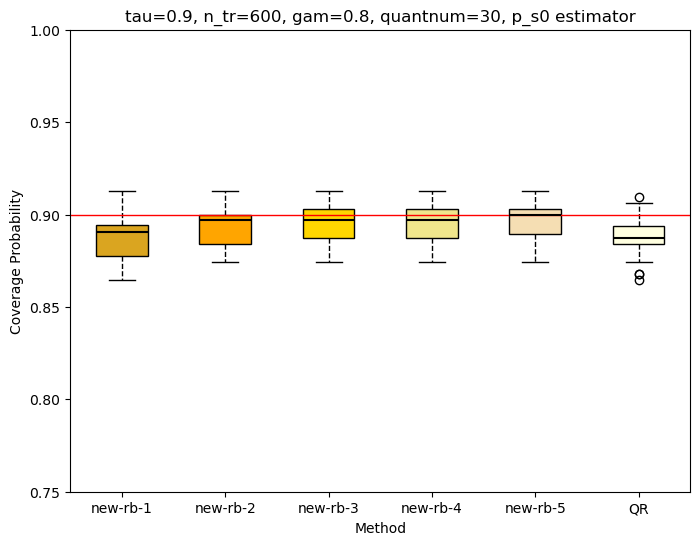

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(8, 6))

bplot_new_cov = data_new_rb_cov.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })

colors = [
    'goldenrod', 'orange', 'gold', 'khaki', 'wheat', 'lightyellow','skyblue'
]

colors2 = [
    'darkseagreen','limegreen' ,'greenyellow','yellowgreen','lightgreen','honeydew','skyblue'
]
for patch, color in zip(bplot_new_cov.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_cov.yaxis.grid(False)
bplot_new_cov.xaxis.grid(False)
bplot_new_cov.set_xlabel("Method")
bplot_new_cov.set_ylabel("Coverage Probability")

plt.axhline(y=0.90, color='red', linestyle='-', linewidth=1)
plt.ylim(0.75,1)
#plt.savefig('fig/new_rb_cov_o_gam0.8_nr100_qnum10.png')
plt.show()
plt.savefig('cov_v2.png')

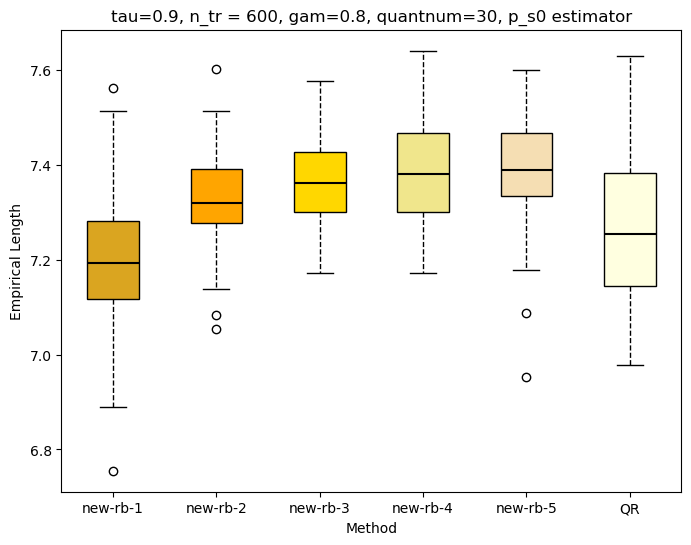

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(8, 6))

bplot_new_len = data_new_rb_len.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })


for patch, color in zip(bplot_new_len.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_len.yaxis.grid(False)
bplot_new_len.xaxis.grid(False)
bplot_new_len.set_xlabel("Method")
bplot_new_len.set_ylabel("Empirical Length")
#plt.savefig('fig/new_len_o_gam0.8_nr100_qnum10.png')
plt.show()
plt.savefig('len_v2.png')